## VGG Architecture

We will build a like VGG network with some modification in the network shape. VGG is well known architecture released by Oxford university. Based on ILSVRC-2014 submission, VGG secured the first and the second places in the localization and classification tasks respectively. 

![](assets/vgg1.jpg)

![](assets/vgg2.jpg)

To install opencv conda:
- conda install -c conda-forge opencv
To install Tensorflow conda:
- conda install -c conda-forge tensorflow

In [1]:
import tensorflow as tf
from os import walk
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

## Create TF Gate
"placeholder" is a gate for us to feed the TF graph.
In this case, we want to classify face gender, So there are two classes: Male and female.
The face image input is a color image in which 60 x 60 shape.

In [2]:
num_class = 2
x_input = tf.placeholder(dtype=tf.float32, shape=[None, 60, 60, 3], name='x_input')
y_output = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='y_input')

## Build First Convolution Block
Based on VGG architecture, the first block has 224x224x64 in shape. But, we built a placeholder for 60x60 image, so it will be modified to 60x60x64 in shape.
60 is image width,
60 is image heights, and
64 is the num of filter

In [3]:
b1_c1 = tf.nn.conv2d(x_input, tf.Variable(tf.truncated_normal(shape=[3, 3, 3, 64], stddev=0.05)), [1,1,1,1], 'SAME')
b1_c1 += tf.Variable(tf.constant(0.05, shape=[64]))

b1_c2 = tf.nn.conv2d(b1_c1, tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 64], stddev=0.05)), [1,1,1,1], 'SAME')
b1_c2 += tf.Variable(tf.constant(0.05, shape=[64]))

b1_p = tf.nn.max_pool(b1_c2, [1, 2, 2, 1], [1,2,2,1], 'SAME')
b1_p

<tf.Tensor 'MaxPool:0' shape=(?, 30, 30, 64) dtype=float32>

## Build Second Convolution Block

In [4]:
b2_c1 = tf.nn.conv2d(b1_p, tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], stddev=0.05)), [1,1,1,1], 'SAME')
b2_c1 += tf.Variable(tf.constant(0.05, shape=[128]))

b2_c2 = tf.nn.conv2d(b2_c1, tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 128], stddev=0.05)), [1,1,1,1], 'SAME')
b2_c2 += tf.Variable(tf.constant(0.05, shape=[128]))

b2_p = tf.nn.max_pool(b2_c2, [1, 2, 2, 1], [1,2,2,1], 'SAME')
b2_p

<tf.Tensor 'MaxPool_1:0' shape=(?, 15, 15, 128) dtype=float32>

## Build Third Convolution Block

In [5]:
b3_c1 = tf.nn.conv2d(b2_p, tf.Variable(tf.truncated_normal(shape=[3, 3, 128, 256], stddev=0.05)), [1,1,1,1], 'SAME')
b3_c1 += tf.Variable(tf.constant(0.05, shape=[256]))

b3_c2 = tf.nn.conv2d(b3_c1, tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 256], stddev=0.05)), [1,1,1,1], 'SAME')
b3_c2 += tf.Variable(tf.constant(0.05, shape=[256]))

b3_c3 = tf.nn.conv2d(b3_c2, tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 256], stddev=0.05)), [1,1,1,1], 'SAME')
b3_c3 += tf.Variable(tf.constant(0.05, shape=[256]))

b3_p = tf.nn.max_pool(b3_c3, [1, 2, 2, 1], [1,2,2,1], 'SAME')
b3_p

<tf.Tensor 'MaxPool_2:0' shape=(?, 8, 8, 256) dtype=float32>

## Build Fourth Convolution Block

In [6]:
b4_c1 = tf.nn.conv2d(b3_p, tf.Variable(tf.truncated_normal(shape=[3, 3, 256, 512], stddev=0.05)), [1,1,1,1], 'SAME')
b4_c1 += tf.Variable(tf.constant(0.05, shape=[512]))

b4_c2 = tf.nn.conv2d(b4_c1, tf.Variable(tf.truncated_normal(shape=[3, 3, 512, 512], stddev=0.05)), [1,1,1,1], 'SAME')
b4_c2 += tf.Variable(tf.constant(0.05, shape=[512]))

b4_c3 = tf.nn.conv2d(b4_c2, tf.Variable(tf.truncated_normal(shape=[3, 3, 512, 512], stddev=0.05)), [1,1,1,1], 'SAME')
b4_c3 += tf.Variable(tf.constant(0.05, shape=[512]))

b4_p = tf.nn.max_pool(b4_c3, [1, 2, 2, 1], [1,2,2,1], 'SAME')
b4_p

<tf.Tensor 'MaxPool_3:0' shape=(?, 4, 4, 512) dtype=float32>

### Note:
our fourth convolution block has shape (?, 4, 4, 512). So its small enough to be flattened or in other word we dont need to make a fifth convolution block as like as VGG does. 

In [7]:
flattened = tf.contrib.layers.flatten(b4_p)
fc1 = tf.matmul(flattened, tf.Variable(tf.truncated_normal([4*4*512, 500], stddev=0.05)))
fc1 += tf.Variable(tf.constant(0.05, shape=[500]))
fc2 = tf.matmul(fc1, tf.Variable(tf.truncated_normal([500, 10], stddev=0.05)))
fc2 += tf.Variable(tf.constant(0.05, shape=[10]))
fc2

<tf.Tensor 'add_11:0' shape=(?, 10) dtype=float32>

Softamx Function:
![](assets/softmax.jpg)

In [8]:
output = tf.nn.softmax(fc2)

## Losses and Optimizer
loss: for counting the distance of predicted tensor with the true label, optimizer: for minimizing the loss 

In [9]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc2, labels=y_output))
optimizer =  tf.train.AdamOptimizer(1e-4).minimize(loss)

y_pred = tf.argmax(output, axis=1)
correct = tf.equal(y_pred, tf.argmax(y_output, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

## Saver and Session


In [10]:
saver = tf.train.Saver()
session = tf.InteractiveSession()
save_path = 'checkpoints/'
session.run(tf.global_variables_initializer())

## Image Pipeline
In this section we will build a pipeline for feeding image to our network.

In [11]:
def get_fileNames(path):
    f = []
    for (dirpath, dirnames, filenames) in walk(path):
        f.extend(filenames)
        break
    return f

In [12]:
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
images = []
labels = []

for i in classes:
    path = 'dataset/' + i + "/"
    files = get_fileNames(path)
    for j in files:
        im = cv2.imread(path + j)
        im = cv2.resize(im, (60, 60))
        lbl = np.zeros(10)
        lbl[int(i)] = 1.0
        images.append(im)
        labels.append(lbl)
        
images = np.array(images)
images = images.astype(np.float32)
images /= 255

labels = np.array(labels)

Now, we want to see the train images

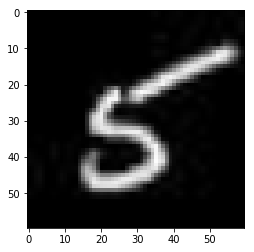

[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [13]:
import random
i = random.randint(1, 600)
plt.imshow(images[i])
plt.show()
print (labels[i])

In [14]:
train_losses = []
val_losses = []

In [15]:
def optimize(iterations):
    im, lb = shuffle(images, labels)
    train_images  = im[: 400]
    train_labels = lb[: 400]
    val_images = im[400:]
    val_labels = lb[400:]
    
    best_loss = 100.0
    
    for i in range(iterations):
        sign = '-'
        
        '''
        for i in range(len(val_images)):
            plt.imshow(train_images[i])
            plt.show()
            print train_labels[i]
        '''
    
        train_feed_dict={x_input:train_images, y_output:train_labels}
        val_feed_dict = {x_input:val_images, y_output:val_labels}
        
        session.run(optimizer, train_feed_dict)
        train_loss = session.run(loss, train_feed_dict)
        val_loss = session.run(loss, val_feed_dict)
        train_accuracy = session.run(accuracy, train_feed_dict)
        val_accuracy = session.run(accuracy, val_feed_dict)
        
        train_losses.append(train_loss)
        
        if val_loss < best_loss:
            saver.save(sess=session, save_path=save_path + "model1")
            best_loss = val_loss
            sign = '*'
        
        print ('Epoch: {0}, Train Loss: {1:1.3}, Train Accu: {2:1.3}, Val Loss: {3:1.3}, Val Accu: {4:1.3}, {5}'.format(i, train_loss, train_accuracy, val_loss, val_accuracy, sign))

In [16]:
optimize(100)

Epoch: 0, Train Loss: 1.98e+02, Train Accu: 0.112, Val Loss: 2.34e+02, Val Accu: 0.095, -
Epoch: 1, Train Loss: 3.4e+02, Train Accu: 0.115, Val Loss: 3.85e+02, Val Accu: 0.09, -
Epoch: 2, Train Loss: 4.08e+02, Train Accu: 0.14, Val Loss: 4.23e+02, Val Accu: 0.095, -
Epoch: 3, Train Loss: 4.24e+02, Train Accu: 0.123, Val Loss: 4.08e+02, Val Accu: 0.105, -
Epoch: 4, Train Loss: 4.15e+02, Train Accu: 0.132, Val Loss: 3.83e+02, Val Accu: 0.16, -
Epoch: 5, Train Loss: 3.68e+02, Train Accu: 0.135, Val Loss: 3.34e+02, Val Accu: 0.17, -
Epoch: 6, Train Loss: 3.03e+02, Train Accu: 0.195, Val Loss: 2.76e+02, Val Accu: 0.255, -
Epoch: 7, Train Loss: 2.45e+02, Train Accu: 0.183, Val Loss: 2.25e+02, Val Accu: 0.25, -
Epoch: 8, Train Loss: 1.24e+02, Train Accu: 0.22, Val Loss: 1.16e+02, Val Accu: 0.295, -
Epoch: 9, Train Loss: 1.05e+02, Train Accu: 0.175, Val Loss: 1.02e+02, Val Accu: 0.135, -
Epoch: 10, Train Loss: 1.02e+02, Train Accu: 0.195, Val Loss: 1.07e+02, Val Accu: 0.165, -
Epoch: 11, Train

KeyboardInterrupt: 

In [ ]:
plt.plot()